<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/tpnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP réseau de neurones

### Objectif
L'objectif de ce tp est de se familiariser avec la paradigme essentielle de l'apprentissage par ordinateur : une base d'apprentissage pour apprendre et une base de test pour évaluer.

### Demarche
La demarche repose principalement sur la recherche de jeux de données apprentissage et test sur lesquels un algorithme fixé a un comportement demandé.

Indépendamment, l'ensemble du code étant modifiable, il invite à être modifié (l'algorithme principal peut notamment être remplacé par un plus proche voisin) pour explorer différemment ces notions. De plus la selection de la répartition train/test peut être faites aléatoirement à partir d'une distribution fixe.

### À noter
**À noter qu'une version beaucoup plus "cool" peut être trouvé ici : https://playground.tensorflow.org avec le désavantage de mettre l'accent sur le réseau et non sur les données comme c'est l'objectif ici.**

Néanmoins, compte tenu de la qualité de cette application (n'est pas google qui veut), le tp peut +/- être fait sur ce site plutôt que dans ce notebook.

## La boite noire

L'ensemble des fonctions ci dessous n'est pas voué à être comprise/modifié en première lecture.
Cela implémente une fonction qui étant donnée une base d'apprentissage et une base de test, réalise une apprentissage et une évaluation.

In [0]:
from __future__ import print_function

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd
import torch.autograd.variable

from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import clear_output
from time import sleep

def visualize_current_model_behaviour(trainingdata,testingdata,model):
    data = {}
    data["train"] = trainingdata
    data["test"] = testingdata
    
    grid = {}
    grid["train"] = np.ones((50,50,3),dtype=int)
    grid["test"] = np.ones((50,50,3),dtype=int)
    for traintest in ["train","test"]:
        X,Y = data[traintest]
        for i in range(X.shape[0]):
            row,col = X[i][0],X[i][1]
            if Y[i]==1:
                grid[traintest][row][col][0]=0
                grid[traintest][row][col][2]=0
            else:
                grid[traintest][row][col][0]=0
                grid[traintest][row][col][1]=0
    
    grid["alldata"] = grid["train"]*grid["test"]
    
    batch = np.zeros((50*50,2),dtype=float)
    for row in range(50):
        for col in range(50):
            batch[row*50+col][0]=row
            batch[row*50+col][1]=col
    prediction = model.getPredictedClass(batch)
    
    
    grid["pred"] = np.ones((50,50,3),dtype=int)*255
    for row in range(50):
        for col in range(50):
            if prediction[row*50+col] == 1:
                grid["pred"][row][col][0]=175
                grid["pred"][row][col][2]=175
            else:
                grid["pred"][row][col][0]=175
                grid["pred"][row][col][1]=175
    
    grid["train_error"] = np.ones((50,50,3),dtype=int)*255
    grid["test_error"] = np.ones((50,50,3),dtype=int)*255
    for traintest in ["train","test"]:
        X,Y = data[traintest]
        for i in range(X.shape[0]):
            row,col = X[i][0],X[i][1]
            if prediction[row*50+col] != Y[i]:
                grid[traintest+"_error"][row][col][1]=0
                grid[traintest+"_error"][row][col][2]=0
    
    for key in grid:
        grid[key][0,:,:]=0
        grid[key][49,:,:]=0
        grid[key][:,0,:]=0
        grid[key][0,49,:]=0
    
    tmp = np.concatenate((grid["alldata"]*255,grid["train"]*255,grid["test"]*255), axis=1)
    tmp2 = np.concatenate((grid["pred"],grid["train_error"],grid["test_error"]), axis=1)
    tmp3 = np.concatenate((tmp,tmp2),axis=0)
    return tmp3


def train_test_deep_network(trainingdata,testingdata,model,nbIteration):
    model.updateweights(trainingdata)

    for iteration in range(nbIteration-1):
        loss = model.updateweights(trainingdata)
        
        if iteration%50==0:
          visu = visualize_current_model_behaviour(trainingdata,testingdata,model)

          clear_output()
          plt.imshow(visu)
          plt.show()
          sleep(3)


 
class Net(nn.Module):
    def getPredictedClass(self,x):
        variablex = torch.autograd.Variable(torch.Tensor(x.astype(float)))
        variableoutput = self.forward(variablex)
        prob = variableoutput.cpu().data.numpy()
        return np.argmax(prob,axis=1)
    
    def updateweights(self,batchfromtrain):
        x,y = batchfromtrain
        variablex = torch.autograd.Variable(torch.Tensor(x.astype(float)))
        variabley = torch.autograd.Variable(torch.from_numpy(y).long())
        variableoutput = self.forward(variablex)
        
        loss = self.losslayer(variableoutput,variabley)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()        
        return loss.cpu().data.numpy()
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 30, bias=True)
        self.fc2 = nn.Linear(30, 30, bias=True)
        self.fc2bis = nn.Linear(30, 30, bias=True)
        self.fc3 = nn.Linear(30, 2, bias=True)
        
        self.train()
        
        
        self.lr = 0.1
        self.momentum = 0.5
        self.optimizer = optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum)
        self.losslayer = nn.CrossEntropyLoss()

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x/30))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc2bis(x))
        x = self.fc3(x)
        return x
        
class NearestNeighbourg:
    def getPredictedClass(self,x):
        if len(x.shape)==1:        
            distances = [(np.sum((x-self.X[i])*(x-self.X[i])),i) for i in range(self.X.shape[0])]
            d,argmin = min(distances)
            return self.Y[argmin]
        else:
            y = [self.getPredictedClass(x[i]) for i in range(x.shape[0])]
            return np.asarray(y)
    
    def updateweights(self,x,y):
        self.X = x
        self.Y = y 


def data_from_grid_label(gridlabel):
    X,Y = [],[]
    tmp = np.zeros((1,2),dtype=int)
    for row in range(10):
        for col in range(10):
            tmp[0][0]=row*5+2
            tmp[0][1]=col*5+2
            if gridlabel[row][col] == '+':
                X.append(tmp.copy())
                Y.append(1)
            if gridlabel[row][col] == '-':
                X.append(tmp.copy())
                Y.append(0)
    return np.concatenate(X,axis=0),np.asarray(Y)

In [0]:
def observe_network_behaviour_on_griddata(gridlabeltrain,gridlabeltest):
    model = Net()
    trainingdata,testingdata = data_from_grid_label(gridlabeltrain),data_from_grid_label(gridlabeltest)
    train_test_deep_network(trainingdata,testingdata,model,300)

## Exemples d'apprentissage :

Faites tourner les 3 apprentissages ci dessous pour vous familiariser avec le code.

Le code produit 6 fenêtres : 
A,B,C
D,E,F

A représente la distribution des données
B représente les données de train
C représente les données de test
D représente les prédictions de l'algorithme
E représente les erreurs d'apprentissage (en rouge)
F représente les erreurs de test (en rouge)

**ATTENTION : n'hésitez pas à relancer chaque apprentissage 2 fois : l'apprentissage étant stochastique, il y a toujours un risque de divergence même sur des problèmes aussi simples...**


### CAS 1 : linéaire

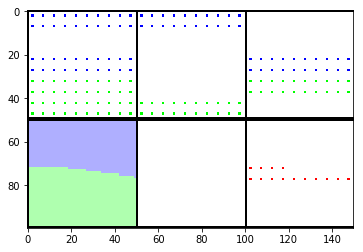

In [3]:
train = [
['-','-','-','-','-','-','-','-','-','-'],
['-','-','-','-','-','-','-','-','-','-'],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
['+','+','+','+','+','+','+','+','+','+'],
['+','+','+','+','+','+','+','+','+','+']]

test = [
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
['-','-','-','-','-','-','-','-','-','-'],
['-','-','-','-','-','-','-','-','-','-'],
['+','+','+','+','+','+','+','+','+','+'],
['+','+','+','+','+','+','+','+','+','+'],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' ']]

observe_network_behaviour_on_griddata(train,test)


### CAS 2 : cercle

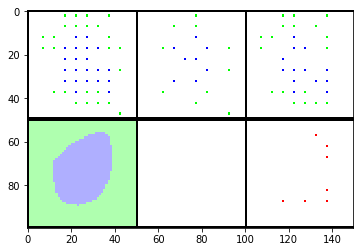

In [4]:
train = [
[' ',' ',' ',' ',' ','+',' ',' ',' ',' '],
[' ',' ',' ','+',' ','+',' ',' ',' ',' '],
[' ',' ',' ',' ',' ','-',' ',' ',' ',' '],
[' ',' ','+','-',' ',' ','-',' ','+',' '],
[' ',' ',' ',' ','-','-',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ','-',' ','+',' '],
[' ',' ',' ','-',' ','-',' ',' ',' ',' '],
[' ',' ','+',' ',' ',' ','+',' ',' ',' '],
[' ',' ',' ',' ',' ','+',' ',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ','+',' ']]

test = [
[' ',' ',' ','+','+',' ',' ','+',' ',' '],
[' ',' ',' ','+','+',' ','+',' ',' ',' '],
[' ','+','+',' ','-',' ',' ','+',' ',' '],
[' ','+',' ',' ','-','-',' ','+',' ',' '],
[' ',' ',' ','-',' ',' ',' ',' ',' ',' '],
[' ',' ',' ','-','-','-',' ','-',' ',' '],
[' ',' ',' ',' ','-',' ','-','-',' ',' '],
[' ',' ','+','+','-','+',' ','-',' ',' '],
[' ',' ',' ',' ','+','+','+','+',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' ']]

observe_network_behaviour_on_griddata(train,test)

CAS 3 : xor

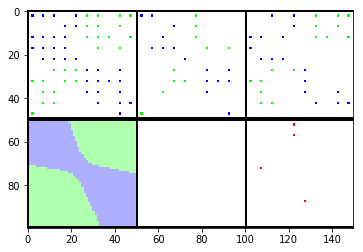

In [5]:
train = [
['-','-',' ',' ',' ','+',' ',' ',' ',' '],
[' ',' ',' ','-',' ','+',' ',' ',' ',' '],
[' ',' ','-',' ',' ','+',' ',' ',' ',' '],
[' ','-','-','-',' ',' ','+',' ','+',' '],
[' ',' ',' ',' ','-',' ',' ',' ',' ',' '],
[' ',' ',' ','+',' ',' ','-',' ','-',' '],
[' ',' ',' ','+','+',' ','-','-','-',' '],
[' ',' ','+',' ',' ',' ','-',' ',' ',' '],
[' ',' ',' ',' ',' ',' ',' ',' ',' ',' '],
['+',' ',' ',' ',' ',' ',' ',' ','-',' ']]

test = [
['=','=','-',' ','-','=','+',' ','+','+'],
[' ',' ',' ','=','-','=','+',' ','+',' '],
['-','-','=','-',' ','=','+','+',' ','+'],
['-','=','=','=',' ',' ','=',' ','=',' '],
[' ','-','-','-','=',' ',' ',' ',' ',' '],
[' ',' ','+','=','+','-','=',' ','=',' '],
['+','+',' ','=','=','-','=','=','=',' '],
[' ','+','=',' ',' ','-','=',' ','-',' '],
[' ','+','+',' ',' ',' ','-',' ','-','-'],
['=',' ',' ',' ',' ',' ',' ',' ','=',' ']]

observe_network_behaviour_on_griddata(train,test)  

## Maintenant c'est à vous :

### Q1
Le réseau fait (normalement) plus d'erreur sur le cas linéaire que sur les autres... En effet, la répartition des données en train et test est très défavorable. 

=> Rerépartisser les données entre train et test de sorte à n'avoir aucune erreur.



In [6]:
print("TODO")

TODO


### Q2

Trouver une distribution train/test sur laquelle l'algorithme ne donne aucune réponse juste en test : n'hésitez pas à vous placer dans le pire cas.

In [7]:
print("TODO")

TODO


### Q3

Étendez le cas "xor", de 4 à 8 rectangles (4 par ligne sur 2 lignes) avec une distribution train/test favorable



In [8]:
print("TODO")

TODO


Puis de 8 à 16 rectangles (4x4) toujours avec une distribution train/test favorable.

Qu'observer vous avec le passage de 8 à 16 ? Comment l'expliquer vous ?

In [9]:
print("TODO")

TODO


In [0]:
def observe_plusprochevoisin_behaviour_on_griddata(gridlabeltrain,gridlabeltest):
    model = NearestNeighbourg()
    trainingdata,testingdata = data_from_grid_label(gridlabeltrain),data_from_grid_label(gridlabeltest)
    train_test_deep_network(trainingdata,testingdata,model,1)

### Q4 (pour aller plus loin)

Refaites ces expériences avec la fonction suivante qui utilise un plus proche voisin au lieu d'un réseau de neurones (si x1,...,xK,y1,...,yK sont les données de train, x aura la classe yk avec xk le point tel que ||x-xi|| soit minimal)


In [11]:
print("TODO")

TODO


### Q5 (plus dur)

Normalement, dans ce cas particulier, le plus proche voisin est meilleur que le réseau de neurone sur la grille 4x4.

Mais l'inverse est vrai sur des problèmes plus simple : trouver une distribution sur laquelle le réseau de neurones est meilleur que le plus proche voisin (avec une répartition train/test honnete).

In [12]:
print("TODO")

TODO


### Q6 (pour aller plus loin)

coder une fonction qui répartie train/test uniformément à partir d'une même densité.

Reproduisez les expériences en tirant uniformément la répartition train/test. Qu'observer vous ?

In [13]:
print("TODO")

TODO
